In [1]:
import numpy as np
import pandas as pd

from data.dataset import StockDataset
from data.scaler import HybridScaler
from data.split import StratifiedTimeSeriesSplit
from model.arima import grid_search
from model.eval import moving_average

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
dataset = StockDataset('^GSPC')
df = dataset.get_hist(start_date='1950-01-01', end_date='2021-10-23', time_interval='daily')

In [3]:
x = pd.concat(
    [df, 
     dataset.lookback_agg(lookback_len=30), 
     dataset.lookback_agg(lookback_len=60), 
     dataset.lookback_agg(lookback_len=120)],
    axis=1)

y = dataset.get_change_forecast_label(forecast_len=30, is_up=False, method='past_all')

In [4]:
# TRAIN_START = '1951-01-01'
TRAIN_START = '1988-01-10'
TEST_START = '2016-01-01'
TEST_END = '2019-12-01'

train_x = x[TRAIN_START:TEST_START]
train_y = y[TRAIN_START:TEST_START]
test_x = x[TEST_START:TEST_END]
test_y = y[TEST_START:TEST_END]

split = TimeSeriesSplit(n_splits=10, test_size=120)
# split = StratifiedTimeSeriesSplit(n_splits=10, test_size=120, min_positive_ratio=0.25)

# LogisticRegression

In [5]:
pipeline = Pipeline(steps=[
    ('scaler', HybridScaler()), 
    ('model', LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga'))
])

In [6]:
results = cross_validate(pipeline, train_x, train_y, cv=split, scoring='accuracy')

In [7]:
results['test_score'].mean()

0.7558333333333334

In [8]:
pipeline.fit(train_x, train_y)
pred_y = pipeline.predict(test_x)

confusion_matrix(test_y, pred_y)

array([[532, 229],
       [114, 110]])

In [9]:
from sklearn.metrics import fbeta_score
print(f'Accuracy: {(test_y == pred_y.reshape(-1)).mean()}')
print(f'F1:{fbeta_score(test_y, pred_y, beta=1)}')
print(f'F2:{fbeta_score(test_y, pred_y, beta=2)}')

Accuracy: 0.6517766497461929
F1:0.3907637655417407
F2:0.4453441295546558


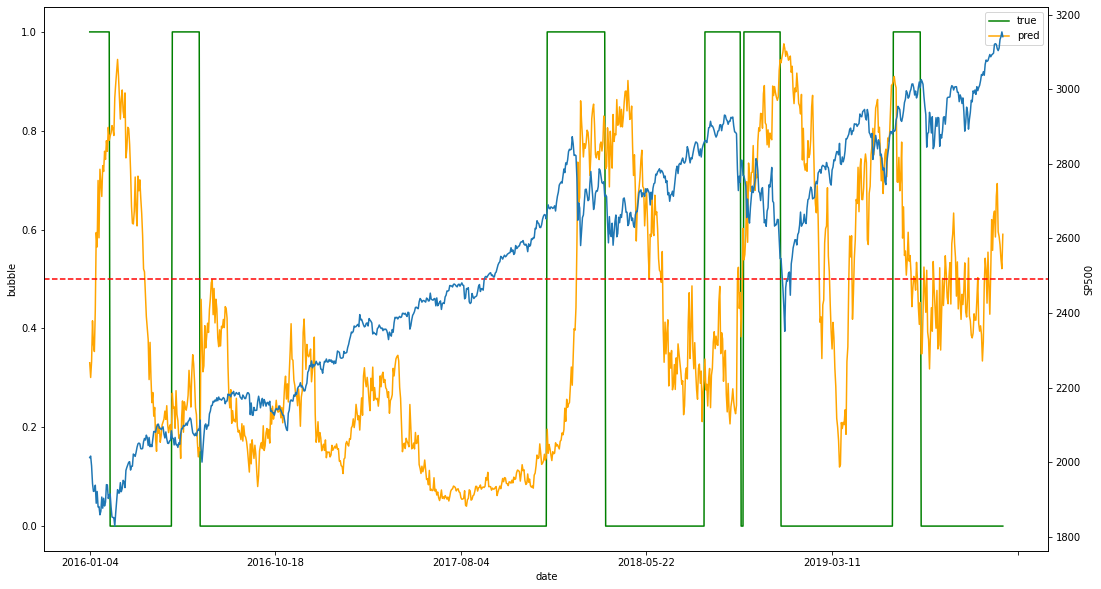

In [10]:
# test_df = moving_average(test_y, pipeline.predict_proba(test_x)[:, 1])
test_df = pd.DataFrame({'true': test_y, 'pred': pipeline.predict_proba(test_x)[:, 1]})


ax1 = test_df.plot(figsize=(18, 10), color=['g', 'orange'])
ax1.set_ylabel('bubble')
ax1.axhline(y=0.5, color='r', linestyle='--')

ax2 = ax1.twinx() 
ax2.set_ylabel('SP500')
ax2 = test_x['close'].plot()

# RandomForecast

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
pipeline = Pipeline(steps=[
    ('scaler', HybridScaler()), 
    ('model', RandomForestClassifier(n_estimators=200, random_state=1))
])

In [13]:
results = cross_validate(pipeline, train_x, train_y, cv=split, scoring='accuracy')

In [14]:
results['test_score'].mean()

0.7825

In [15]:
pipeline.fit(train_x, train_y)
pred_y = pipeline.predict(test_x)

confusion_matrix(test_y, pred_y)

array([[219, 542],
       [ 81, 143]])

In [16]:
print(f'Accuracy: {(test_y == pred_y.reshape(-1)).mean()}')
print(f'F1:{fbeta_score(test_y, pred_y, beta=1)}')
print(f'F2:{fbeta_score(test_y, pred_y, beta=2)}')

Accuracy: 0.36751269035532996
F1:0.3146314631463146
F2:0.4522454142947501


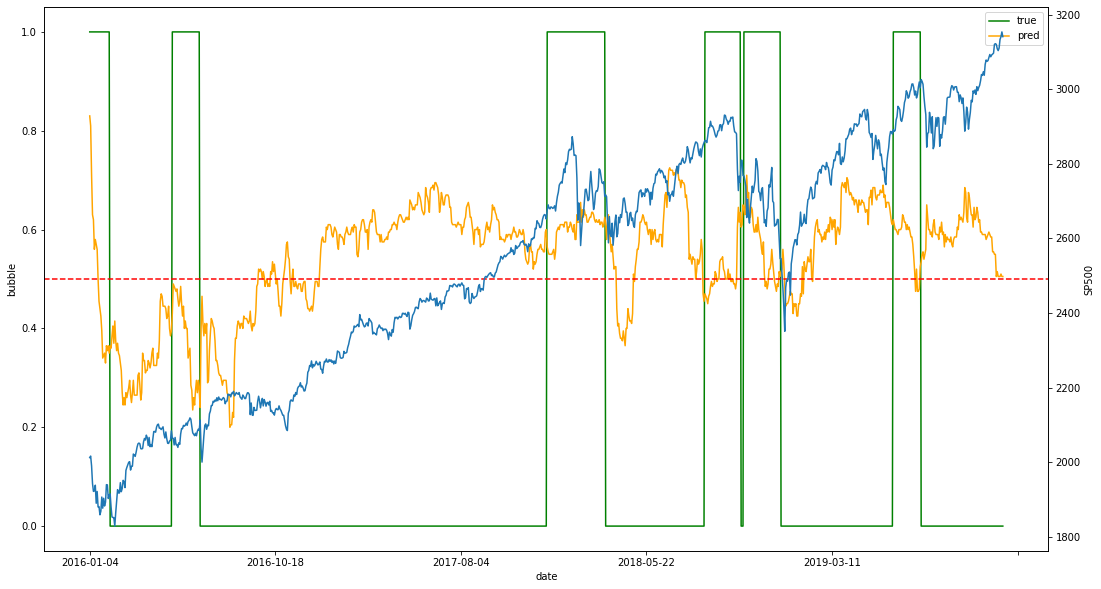

In [17]:
# test_df = moving_average(test_y, pipeline.predict_proba(test_x)[:, 1])
test_df = pd.DataFrame({'true': test_y, 'pred': pipeline.predict_proba(test_x)[:, 1]})


ax1 = test_df.plot(figsize=(18, 10), color=['g', 'orange'])
ax1.set_ylabel('bubble')
ax1.axhline(y=0.5, color='r', linestyle='--')

ax2 = ax1.twinx() 
ax2.set_ylabel('SP500')
ax2 = test_x['close'].plot()